# Trauma Transfer Learning Experiment

This notebook compares baseline survival models and a transfer learning approach using Indian and Jordan trauma datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

sns.set(style='whitegrid')


## Load datasets

In [2]:
india_file = 'trauma_india_brain_injury.csv'
jordan_file = 'traumatic_brain_injury.csv'

cols_india = ['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','doa','toa','dodd','todd','died']
india = pd.read_csv(india_file, usecols=cols_india)

cols_jordan = ['Gender','age of diagnosis','ER-HR','ER-RR','ER-systolic BP','GCS in ER','length of stay in the hospital (in days)','outcome']
jordan = pd.read_csv(jordan_file, usecols=cols_jordan)


In [3]:
india

,age,sex,doa,toa,sbp_1,rr_1,hr_1,gcs_t_1,died,dodd,todd
0,40,Male,7/8/2276,16:00,120.0,22.0,70.0,15.0,No,7/21/2276,16:00
1,27,Male,7/31/2280,17:30,130.0,15.0,84.0,5.0,No,9/3/2280,16:00
2,45,Male,8/1/2108,13:40,110.0,NaN,80.0,15.0,No,8/7/2108,12:40
3,50,Male,7/16/2132,21:50,NaN,24.0,88.0,4.0,Yes,7/19/2132,7:30
4,50,Female,7/3/2047,23:50,130.0,22.0,80.0,3.0,No,7/6/2047,12:30
...,...,...,...,...,...,...,...,...,...,...,...
7973,8,Female,9/27/2150,7:00,102.0,NaN,100.0,11.0,No,9/28/2150,12:00
7974,45,Male,9/17/2174,13:20,130.0,14.0,72.0,11.0,No,9/26/2174,10:00
7975,11,Male,9/16/2237,21:50,100.0,NaN,88.0,15.0,No,9/19/2237,10:00
7976,45,Female,NaN,NaN,110.0,24.0,90.0,6.0,Yes,1/1/2196,19:40


In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
jordan_numeric = jordan.select_dtypes(include=[np.number])

# Perform iterative imputation
imputer = IterativeImputer(random_state=0)
jordan_imputed_array = imputer.fit_transform(jordan_numeric)

# Replace numeric columns in jordan with imputed values
jordan[jordan_numeric.columns] = jordan_imputed_array

print(jordan.head())

   Gender  age of diagnosis  GCS in ER        ER-HR      ER-RR ER-systolic BP  \
0  Female               6.0       15.0  tachycardia  tachypnea         normal   
1    Male               7.0       15.0       normal     normal         normal   
2    Male              13.0        3.0       normal     normal         normal   
3    Male               9.0       13.0       normal     normal         normal   
4    Male               1.5       15.0       normal     normal         normal   

   length of stay in the hospital (in days)   outcome  
0                                       5.0  survival  
1                                       7.0  survival  
2                                       7.0  survival  
3                                      28.0  survival  
4                                       3.0  survival  


## Feature engineering

In [5]:
# Pediatric reference ranges (example, adjust as needed for your population)
def hr_category(age, hr):
    # Age in years, HR in bpm
    if pd.isnull(hr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if hr > 160: return 'tachycardia'
        else: return 'normal'
    elif age < 3:
        if hr > 150: return 'tachycardia'
        else: return 'normal'
    elif age < 6:
        if hr > 140: return 'tachycardia'
        else: return 'normal'
    elif age < 12:
        if hr > 120: return 'tachycardia'
        else: return 'normal'
    else:
        if hr > 100: return 'tachycardia'
        else: return 'normal'

def rr_category(age, rr):
    # Age in years, RR in breaths/min
    if pd.isnull(rr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if rr > 60: return 'tachypnea'
        else: return 'normal'
    elif age < 3:
        if rr > 40: return 'tachypnea'
        else: return 'normal'
    elif age < 6:
        if rr > 34: return 'tachypnea'
        else: return 'normal'
    elif age < 12:
        if rr > 30: return 'tachypnea'
        else: return 'normal'
    else:
        if rr > 20: return 'tachypnea'
        else: return 'normal'

def sbp_category(age, sbp):
    # Age in years, SBP in mmHg
    if pd.isnull(sbp) or pd.isnull(age):
        return np.nan
    if age < 1:
        if sbp < 70: return 'low'
        else: return 'normal'
    elif age < 10:
        if sbp < 70 + 2*age: return 'low'
        else: return 'normal'
    else:
        if sbp < 90: return 'low'
        else: return 'normal'



In [6]:
def parse_datetime(date_col, time_col):
    dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
    return dt

india['admit_time'] = parse_datetime(india['doa'], india['toa'])
india['discharge_time'] = parse_datetime(india['dodd'], india['todd'])
india['los'] = (india['discharge_time'] - india['admit_time']).dt.total_seconds() / 3600
india['los'] = india['los'].fillna(0)
india['event'] = (india['died'] == 'Yes').astype(int)

jordan['los'] = pd.to_numeric(jordan['length of stay in the hospital (in days)'], errors='coerce')
jordan['event'] = (jordan['outcome'] == 'died').astype(int)

india['sex'] = india['sex'].map({'Male':1,'Female':0})
jordan['Gender'] = jordan['Gender'].map({'Male':1,'Female':0})

features_india = india[['age','sex','sbp_1','hr_1','rr_1','gcs_t_1']].copy()
features_jordan = jordan[['age of diagnosis','Gender','ER-HR','ER-RR','ER-systolic BP','GCS in ER']].copy()
features_jordan.columns = ['age','sex','hr','rr','sbp','gcs']
features_india.columns = ['age','sex','sbp','hr','rr','gcs']


C:\Users\SBSBB\AppData\Local\Temp\ipykernel_38432\3413719261.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\SBSBB\AppData\Local\Temp\ipykernel_38432\3413719261.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\SBSBB\AppData\Local\Temp\ipykernel_38432\3413719261.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')


In [7]:
# Ensure numeric conversion for Indian vital signs before categorization
features_india['hr'] = pd.to_numeric(features_india['hr'], errors='coerce')
features_india['rr'] = pd.to_numeric(features_india['rr'], errors='coerce')
features_india['sbp'] = pd.to_numeric(features_india['sbp'], errors='coerce')
features_india['age'] = pd.to_numeric(features_india['age'], errors='coerce')

# Now apply the categorization functions
features_india['hr_cat'] = [hr_category(a, h) for a, h in zip(features_india['age'], features_india['hr'])]
features_india['rr_cat'] = [rr_category(a, r) for a, r in zip(features_india['age'], features_india['rr'])]
features_india['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_india['age'], features_india['sbp'])]

# For Jordan, use the existing categorical columns (assumed to be ER-HR, ER-RR, ER-systolic BP)
features_jordan['hr_cat'] = features_jordan['hr']
features_jordan['rr_cat'] = features_jordan['rr']
features_jordan['sbp_cat'] = features_jordan['sbp']


# Use correct argument for OneHotEncoder for scikit-learn >= 1.2
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['hr_cat', 'rr_cat', 'sbp_cat']
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on combined categories to ensure same columns
enc.fit(pd.concat([features_india[cat_cols], features_jordan[cat_cols]], axis=0))

X_india_cat = enc.transform(features_india[cat_cols])
X_jordan_cat = enc.transform(features_jordan[cat_cols])

# Replace original columns with encoded
import numpy as np
X_india_final = np.concatenate([features_india[['age','sex','gcs']].fillna(0).values, X_india_cat], axis=1)
X_jordan_final = np.concatenate([features_jordan[['age','sex','gcs']].fillna(0).values, X_jordan_cat], axis=1)

# Update y as before
y_india = np.array([(bool(e), t) for e,t in zip(india['event'], india['los']/24)], dtype=[('event', bool), ('time', float)])
y_jordan = np.array([(bool(e), t) for e,t in zip(jordan['event'], jordan['los'])], dtype=[('event', bool), ('time', float)])


## Exploratory analysis

India rows: 7978
Jordan rows: 112
Indian LOS summary (hours):
count    7978.000000
mean      173.574866
std       338.993580
min      -240.000000
25%        44.166667
50%       109.833333
75%       194.333333
max      8936.333333
Name: los, dtype: float64
Jordan LOS summary (days):
count    112.000000
mean      11.964021
std       16.145693
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max      126.000000
Name: los, dtype: float64


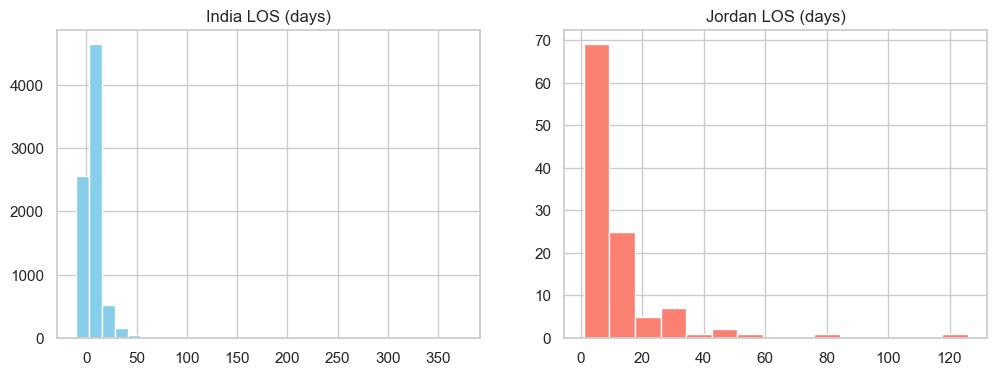

In [8]:
print('India rows:', len(india))
print('Jordan rows:', len(jordan))

print('Indian LOS summary (hours):')
print(india['los'].describe())
print('Jordan LOS summary (days):')
print(jordan['los'].describe())

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(india['los']/24, bins=30, color='skyblue')
axes[0].set_title('India LOS (days)')
axes[1].hist(jordan['los'], bins=15, color='salmon')
axes[1].set_title('Jordan LOS (days)')
plt.show()


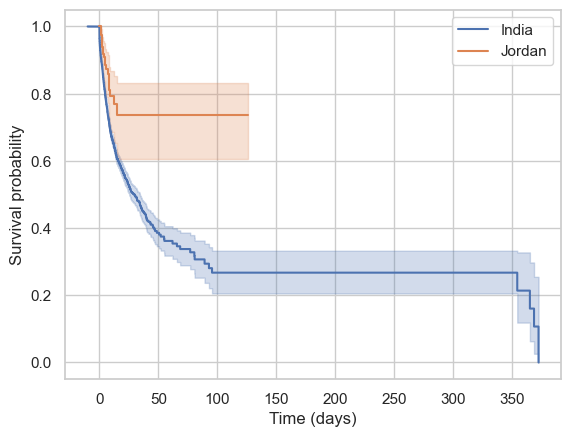

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(durations=india['los']/24, event_observed=india['event'], label='India')
ax = kmf.plot()
kmf.fit(durations=jordan['los'], event_observed=jordan['event'], label='Jordan')
kmf.plot(ax=ax)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
plt.show()


## Baseline Cox model on Jordan data

# Use only numeric and one-hot encoded features for CoxPHFitter
# Use X_jordan_final (age, sex, gcs, one-hot encoded vitals) for baseline Cox model
import pandas as pd

# Create DataFrame for CoxPHFitter
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values



# Remove one-hot columns that are perfectly collinear (sum to 1 across all rows)
def drop_perfectly_collinear_onehot(df, base_cols):
    # Only keep one column per one-hot group
    keep = set(base_cols)
    for prefix in [c.split('_')[0] for c in df.columns if '_' in c]:
        group = [c for c in df.columns if c.startswith(prefix+'_')]
        if len(group) > 1:
            # Keep only the first column in the group
            keep.update(group[:1])
    return df[list(keep)]

# Identify base columns (age, sex, gcs, duration, event)
base_cols = {'age','sex','gcs','duration','event'}

# Apply to Jordan
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values
baseline_data = drop_perfectly_collinear_onehot(baseline_data, base_cols)

cph = CoxPHFitter()
cph.fit(baseline_data, duration_col='duration', event_col='event')
print(cph.summary)
print('Baseline C-index:', concordance_index(baseline_data['duration'], -cph.predict_partial_hazard(baseline_data), baseline_data['event']))


## Transfer learning with gradient boosting

In [10]:
# Use only numeric and one-hot encoded features for gradient boosting survival analysis
# Use X_jordan_final and X_india_final, not features_jordan or features_india (which contain strings)

# Remove samples with negative or zero LOS for survival analysis
# (Observed time must be positive)

# For India
valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# For Jordan
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

"""# Baseline without transfer
gb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)
gb_baseline.fit(X_jordan_gb, y_jordan)
base_cindex = gb_baseline.score(X_jordan_gb, y_jordan)
print('Baseline gradient boosting C-index:', base_cindex)

# Pretrain on India then fine-tune on Jordan
gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
gb_transfer.fit(X_india_gb, y_india)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan_gb, y_jordan)
transfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)
print('Transfer learning C-index:', transfer_cindex)

# Plot example predicted survival curves for Jordan
import matplotlib.pyplot as plt
for fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):
    plt.step(fn.x, fn.y)
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.title('Example predicted curves (Jordan)')
plt.show()"""

"# Baseline without transfer\ngb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)\ngb_baseline.fit(X_jordan_gb, y_jordan)\nbase_cindex = gb_baseline.score(X_jordan_gb, y_jordan)\nprint('Baseline gradient boosting C-index:', base_cindex)\n\n# Pretrain on India then fine-tune on Jordan\ngb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)\ngb_transfer.fit(X_india_gb, y_india)\ngb_transfer.set_params(n_estimators=150)\ngb_transfer.fit(X_jordan_gb, y_jordan)\ntransfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)\nprint('Transfer learning C-index:', transfer_cindex)\n\n# Plot example predicted survival curves for Jordan\nimport matplotlib.pyplot as plt\nfor fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):\n    plt.step(fn.x, fn.y)\nplt.xlabel('Time (days)')\nplt.ylabel('Survival probability')\nplt.title('Example predicted curves (Jordan)')\nplt.show()"

## Robust Transfer Learning Evaluation: 5-Fold Cross-Validation Only

We now evaluate transfer learning using only 5-fold cross-validation (CV) for all models. Both the baseline (Jordan only) and transfer learning (pretrain India, fine-tune Jordan) models are compared using mean C-index and standard deviation across CV folds. This approach ensures robust, publication-quality model evaluation and avoids bias from a single holdout split.

In [11]:
""""""'''"""from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
import numpy as np

# Remove samples with negative or zero LOS for survival analysis
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# Cross-validation (5-fold) on Jordan
def crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X_target):
        gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
        gb_transfer.fit(X_source, y_source)
        gb_transfer.set_params(n_estimators=150)
        gb_transfer.fit(X_target[train_idx], y_target[train_idx])
        cindices.append(gb_transfer.score(X_target[test_idx], y_target[test_idx]))
    return np.mean(cindices), np.std(cindices)

def crossval_cindex_baseline(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X):
        model_ = GradientBoostingSurvivalAnalysis(random_state=0)
        model_.fit(X[train_idx], y[train_idx])
        cindices.append(model_.score(X[test_idx], y[test_idx]))
    return np.mean(cindices), np.std(cindices)

# Baseline CV
cv_cindex_baseline_jordan, cv_cindex_baseline_std_jordan = crossval_cindex_baseline(X_jordan_gb, y_jordan)
print(f'Baseline 5-fold CV C-index: {cv_cindex_baseline_jordan:.3f} ± {cv_cindex_baseline_std_jordan:.3f}')

# Transfer learning CV
cv_cindex_transfer_jordan, cv_cindex_transfer_std_jordan = crossval_cindex_transfer(X_india_gb, y_india, X_jordan_gb, y_jordan)
print(f'Transfer learning 5-fold CV C-index: {cv_cindex_transfer_jordan:.3f} ± {cv_cindex_transfer_std_jordan:.3f}')"""'''""""""

'"""from sklearn.model_selection import KFold\nfrom sksurv.metrics import concordance_index_censored\nimport numpy as np\n\n# Remove samples with negative or zero LOS for survival analysis\nvalid_jordan = jordan[\'los\'] > 0\nX_jordan_gb = X_jordan_final[valid_jordan.values]\ny_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, \'event\'], jordan.loc[valid_jordan, \'los\'])], dtype=[(\'event\', bool), (\'time\', float)])\n\nvalid_india = india[\'los\'] > 0\nX_india_gb = X_india_final[valid_india.values]\ny_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, \'event\'], india.loc[valid_india, \'los\']/24)], dtype=[(\'event\', bool), (\'time\', float)])\n\n# Cross-validation (5-fold) on Jordan\ndef crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n    cindices = []\n    for train_idx, test_idx in kf.split(X_target):\n        gb_transfer = GradientBoosting

## India→Jordan Transfer: Experimental Styles

We compare three approaches for evaluating on the Jordan dataset:

1. **Direct Transfer (No Fine-Tuning):**
   - Train on India only, test directly on Jordan.
2. **Standard Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan (add trees, warm_start), test on Jordan.
3. **Weighted Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan with higher sample weights for Jordan data, test on Jordan.

This allows for a rigorous comparison of transfer learning strategies.

In [12]:
from sksurv.metrics import concordance_index_censored

In [ ]:
# Baseline: Train and evaluate only on Jordan (5-fold cross-validation)
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_jordan = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=150)
    gb_jordan.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_jordan.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices.append(cindex)
print(f'Jordan-only baseline (5-fold CV) C-index: {np.mean(cindices):.3f} ± {np.std(cindices):.3f}')

Jordan-only baseline (5-fold CV) C-index: 0.766 ± 0.224


In [46]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Gradient Boosting": GradientBoostingSurvivalAnalysis(n_estimators=150, random_state=42),
    "Random Forest": RandomSurvivalForest(n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        model.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        preds = model.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(
            y_jordan['event'][test_idx],
            y_jordan['time'][test_idx],
            preds
        )[0]
        cindices.append(cindex)
    results[name] = {
        'Mean C-index': np.mean(cindices),
        'Std Dev': np.std(cindices)
    }

# Display results in a table
results_df = pd.DataFrame(results).T
print(results_df.round(3))


                   Mean C-index  Std Dev
Gradient Boosting         0.766    0.224
Random Forest             0.853    0.103


In [42]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
import numpy as np

model_defs = [
    ("GradientBoostingSurvivalAnalysis", GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=150)),
    ("RandomSurvivalForest", RandomSurvivalForest(random_state=0, n_estimators=150))
]

results = {"baseline": {}, "standard_tl": {}, "weighted_tl": {}}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in model_defs:
    # Baseline (Jordan only)
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        m = model if name == "CoxPHSurvivalAnalysis" else model.__class__(**model.get_params())
        m.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        preds = m.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
        cindices.append(cindex)
    results["baseline"][name] = (np.mean(cindices), np.std(cindices))
    print(f"Baseline ({name}): {np.mean(cindices):.3f} ± {np.std(cindices):.3f}")

    # Standard TL (pretrain India, fine-tune Jordan train fold)
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        m = model if name == "CoxPHSurvivalAnalysis" else model.__class__(**model.get_params())
        if name == "CoxPHSurvivalAnalysis":
            m.fit(X_india_gb, y_india)
            m.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        else:
            m_pre = model.__class__(**model.get_params())
            if hasattr(m_pre, 'warm_start'):
                m_pre.set_params(warm_start=True, n_estimators=100)
                m_pre.fit(X_india_gb, y_india)
                m_pre.set_params(n_estimators=150)
                m_pre.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
                m = m_pre
            else:
                m.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        preds = m.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
        cindices.append(cindex)
    results["standard_tl"][name] = (np.mean(cindices), np.std(cindices))
    print(f"Standard TL ({name}): {np.mean(cindices):.3f} ± {np.std(cindices):.3f}")

    # Weighted TL (pretrain India, fine-tune Jordan train fold with sample weights)
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        m = model if name == "CoxPHSurvivalAnalysis" else model.__class__(**model.get_params())
        if name == "CoxPHSurvivalAnalysis":
            m.fit(X_india_gb, y_india)
            m.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        else:
            m_pre = model.__class__(**model.get_params())
            if hasattr(m_pre, 'warm_start'):
                m_pre.set_params(warm_start=True, n_estimators=100)
                m_pre.fit(X_india_gb, y_india)
                m_pre.set_params(n_estimators=150)
                sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
                m_pre.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
                m = m_pre
            else:
                sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
                m.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
        preds = m.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
        cindices.append(cindex)
    results["weighted_tl"][name] = (np.mean(cindices), np.std(cindices))
    print(f"Weighted TL ({name}): {np.mean(cindices):.3f} ± {np.std(cindices):.3f}")

print("\nSummary Table (mean ± std C-index):")
import pandas as pd
summary = pd.DataFrame({
    'Baseline': {k: f"{v[0]:.3f} ± {v[1]:.3f}" for k, v in results['baseline'].items()},
    'Standard TL': {k: f"{v[0]:.3f} ± {v[1]:.3f}" for k, v in results['standard_tl'].items()},
    'Weighted TL': {k: f"{v[0]:.3f} ± {v[1]:.3f}" for k, v in results['weighted_tl'].items()},
})
display(summary)


Baseline (GradientBoostingSurvivalAnalysis): 0.766 ± 0.224
Standard TL (GradientBoostingSurvivalAnalysis): 0.848 ± 0.130
Weighted TL (GradientBoostingSurvivalAnalysis): 0.813 ± 0.172
Baseline (RandomSurvivalForest): 0.888 ± 0.049
Standard TL (RandomSurvivalForest): 0.817 ± 0.097
Weighted TL (RandomSurvivalForest): 0.817 ± 0.097

Summary Table (mean ± std C-index):


,Baseline,Standard TL,Weighted TL
GradientBoostingSurvivalAnalysis,0.766 ± 0.224,0.848 ± 0.130,0.813 ± 0.172
RandomSurvivalForest,0.888 ± 0.049,0.817 ± 0.097,0.817 ± 0.097


In [14]:
# Weighted fine-tuning: pretrain on India, fine-tune on Jordan with sample weighting, test on Jordan
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
import numpy as np

# Weighted fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold with sample weighting, evaluate on test fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_weighted = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_weighted = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_weighted.fit(X_india_gb, y_india)
    gb_weighted.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
    gb_weighted.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
    preds = gb_weighted.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_weighted.append(cindex)
print(f'Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_weighted):.3f} ± {np.std(cindices_weighted):.3f}')


Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: 0.813 ± 0.172


In [44]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Gradient Boosting": GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42),
    "Random Forest": RandomSurvivalForest(n_estimators=100, random_state=42)  # no warm_start, retrain fully after pretraining
}

results = {}

for model_name, model in models.items():
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        # Pretrain on India if applicable
        model.fit(X_india_gb, y_india)
        
        # Fine-tune if warm_start is supported
        if hasattr(model, "set_params") and "warm_start" in model.get_params():
            model.set_params(n_estimators=150)
            sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
            model.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
        else:
            # For models like RSF that don’t support warm_start, retrain on combined India + Jordan fold
            X_combined = np.concatenate([X_india_gb, X_jordan_gb[train_idx]])
            y_combined = np.concatenate([y_india, y_jordan[train_idx]])
            sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=np.concatenate([
                np.zeros(len(y_india)),  # Assume India events are balanced
                y_jordan['event'][train_idx].astype(int)
            ]))
            model.fit(X_combined, y_combined, sample_weight=sample_weight)

        preds = model.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(
            y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds
        )[0]
        cindices.append(cindex)

    results[model_name] = {
        'Mean C-index': np.mean(cindices),
        'Std Dev': np.std(cindices)
    }

# Display results
results_df = pd.DataFrame(results).T
print("Weighted Fine-Tuning (India → Jordan, 5-fold CV)")
print(results_df.round(3))


Weighted Fine-Tuning (India → Jordan, 5-fold CV)
                   Mean C-index  Std Dev
Gradient Boosting         0.972    0.035
Random Forest             0.831    0.092


In [15]:
# Standard fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold, evaluate on test fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_finetune = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_finetune = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
    gb_finetune.fit(X_india_gb, y_india)
    gb_finetune.set_params(n_estimators=150)
    gb_finetune.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_finetune.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_finetune.append(cindex)
print(f'Standard fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_finetune):.3f} ± {np.std(cindices_finetune):.3f}')


Standard fine-tuning (India→Jordan, 5-fold CV) C-index: 0.848 ± 0.130


In [45]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Gradient Boosting": GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42),
    "Random Forest": RandomSurvivalForest(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    cindices = []
    for train_idx, test_idx in kf.split(X_jordan_gb):
        # Pretrain on India
        model.fit(X_india_gb, y_india)
        
        if hasattr(model, "set_params") and "warm_start" in model.get_params():
            # Continue training on Jordan fold
            model.set_params(n_estimators=150)
            model.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
        else:
            # RSF: fine-tune by retraining on India + Jordan fold (no warm_start)
            X_combined = np.concatenate([X_india_gb, X_jordan_gb[train_idx]])
            y_combined = np.concatenate([y_india, y_jordan[train_idx]])
            model.fit(X_combined, y_combined)

        preds = model.predict(X_jordan_gb[test_idx])
        cindex = concordance_index_censored(
            y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds
        )[0]
        cindices.append(cindex)

    results[model_name] = {
        'Mean C-index': np.mean(cindices),
        'Std Dev': np.std(cindices)
    }

# Display results
results_df = pd.DataFrame(results).T
print("Standard Fine-Tuning (India → Jordan, 5-fold CV)")
print(results_df.round(3))


Standard Fine-Tuning (India → Jordan, 5-fold CV)
                   Mean C-index  Std Dev
Gradient Boosting         0.969    0.029
Random Forest             0.835    0.096


In [16]:
from scipy.stats import wilcoxon

def compare_models(cindex_a, cindex_b, name_a="Model A", name_b="Model B"):
    """
    Performs Wilcoxon signed-rank test to compare two models' C-index values across CV folds.
    
    Parameters:
    - cindex_a: List or array of C-index scores for model A (e.g., baseline)
    - cindex_b: List or array of C-index scores for model B (e.g., fine-tuned)
    - name_a: Optional name for model A (used in print statements)
    - name_b: Optional name for model B

    Returns:
    - None (prints result)
    """
    stat, p = wilcoxon(cindex_a, cindex_b)
    mean_diff = np.mean(np.array(cindex_b) - np.array(cindex_a))
    print(f"\n📊 Comparing: {name_a} vs. {name_b}")
    print(f"Mean difference in C-index: {mean_diff:.3f}")
    print(f"Wilcoxon signed-rank test p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Statistically significant difference (p < 0.05)")
    else:
        print("⚠️ No statistically significant difference (p ≥ 0.05)")


In [47]:
compare_models(
    cindices,                # Jordan-only baseline
    cindices_finetune,       # Standard fine-tuning
    name_a="Jordan-only",
    name_b="Standard Fine-Tuning"
)

compare_models(
    cindices,                
    cindices_weighted,       
    name_a="Jordan-only",
    name_b="Weighted Fine-Tuning"
)

compare_models(
    cindices_finetune,
    cindices_weighted,
    name_a="Standard Fine-Tuning",
    name_b="Weighted Fine-Tuning"
)



📊 Comparing: Jordan-only vs. Standard Fine-Tuning
Mean difference in C-index: -0.006
Wilcoxon signed-rank test p-value: 1.0000
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Jordan-only vs. Weighted Fine-Tuning
Mean difference in C-index: -0.041
Wilcoxon signed-rank test p-value: 0.8125
⚠️ No statistically significant difference (p ≥ 0.05)

📊 Comparing: Standard Fine-Tuning vs. Weighted Fine-Tuning
Mean difference in C-index: -0.035
Wilcoxon signed-rank test p-value: 1.0000
⚠️ No statistically significant difference (p ≥ 0.05)
